# **SPP-3D Dataset**

Mediante este notebook se examinará el dataset SPP-3D obtenido de [Github](https://github.com/akashsengupta1997/SSP-3D). Se usará para evaluar los modelos de forma corporal.

In [1]:
import pywavefront
import numpy as np

## 1. Inspeccionar contenido

In [2]:
shapes = np.load('./ssp-3d/labels/shapes.npy')
genders = np.load('./ssp-3d/labels/genders.npy')
poses = np.load('./ssp-3d/labels/poses.npy')

In [3]:
print("Shapes: ", shapes.shape)
print("Genders: ", genders.shape)
print("Poses: ", poses.shape)

Shapes:  (311, 10)
Genders:  (311,)
Poses:  (311, 72)


In [4]:
shapes[0]

array([ 0.45209095, -0.10660909,  0.03959251,  0.33805674, -0.7632837 ,
        0.9354549 , -0.5134044 ,  0.3841334 , -0.15775895,  0.16816713],
      dtype=float32)

In [5]:
genders[0]

'f'

In [6]:
poses[0]

array([ 0.9119987 , -0.10722127, -3.0152643 , -0.6955288 , -0.0311853 ,
        0.29744783, -0.47107953,  0.04291212, -0.01055432,  0.5167258 ,
        0.02522585,  0.0051317 ,  1.4150488 , -0.13509895, -0.19988556,
        0.61480546,  0.07882223,  0.12850448, -0.13228872, -0.09371068,
        0.00694467, -0.23269707,  0.19864196, -0.14220577, -0.40164572,
       -0.17464897, -0.00454808,  0.11872488,  0.01337123,  0.06709494,
       -0.29391053,  0.08957466,  0.18095769,  0.03830106,  0.043043  ,
       -0.25034443,  0.1369001 , -0.0527221 , -0.24512112, -0.02460125,
       -0.2999442 , -0.2318242 , -0.13846499,  0.38130426,  0.12099928,
       -0.41262275,  0.01479854,  0.22438113, -0.0123816 , -0.15141371,
       -0.5351988 , -0.25043273,  0.1175174 ,  0.4055436 , -0.26969442,
       -0.7254369 ,  0.07159328, -0.4355144 ,  0.87868685, -0.1374476 ,
       -0.6889672 , -0.40986285,  0.07579303, -0.5344964 ,  0.28471023,
       -0.15344091,  0.14516144,  0.10926588, -0.45422137,  0.10

## 2. Comprobar información

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

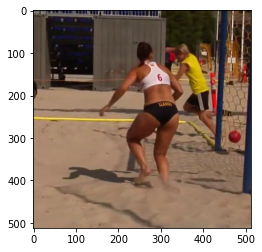

In [8]:
img = mpimg.imread('./ssp-3d/images/beach_handball_vid_001_clip_000_person_001_frame_000007.png')
imgplot = plt.imshow(img)

### 2.1 Obtener vertices con SMPL

In [88]:
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
import torch

In [225]:
smpl_layer = SMPL_Layer(
        center_idx=0,
        gender='female',
        model_root='smplpytorch/native/models')

In [226]:
pose_params = torch.from_numpy(poses[0].reshape(1, poses[0].shape[0]))
shape_params = torch.from_numpy(shapes[0].reshape(1, shapes[0].shape[0]))

In [227]:
print(pose_params.shape)
print(shape_params.shape)

torch.Size([1, 72])
torch.Size([1, 10])


In [228]:
# Forward from the SMPL layer
verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)
faces = smpl_layer.th_faces

In [229]:
verts.shape

torch.Size([1, 6890, 3])

In [230]:
faces.shape

torch.Size([13776, 3])

### 2.2 Dibujar Vertices

In [231]:
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot

In [239]:
def buildMesh(vertices, faces):
    x, y, z = vertices[:,:3].T
    I, J, K = faces.T
    mesh = go.Mesh3d(
                x=x,
                y=y,
                z=z,
                i=I,
                j=J,
                k=K,
                name='',
                showscale=False)
    return mesh

In [237]:
def buildLayout():
    layout = go.Layout(width=500,
                   height=500,
                   scene=dict(aspectmode='data',
                              camera=dict(eye=dict(x=2, y=1.5, z=0.2))), 
                  margin=dict(t=50)) 
    return layout

In [241]:
mesh = buildMesh(verts.reshape(verts.shape[1], verts.shape[2]), faces)
layout = buildLayout()
fig = go.Figure(data=[mesh], layout=layout)
iplot(fig)

In [243]:
thefile = open('test.obj', 'w')
for item in verts.reshape(verts.shape[1], verts.shape[2]):
    thefile.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

for item in faces + 1:
    thefile.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  

thefile.close()

## 3. Evaluación

In [96]:
def compute_pve_neutral_pose_scale_corrected(pose, predicted_smpl_shape, target_smpl_shape, gender):
    """
    Given predicted and target SMPL shape parameters, computes neutral-pose per-vertex error
    after scale-correction (to account for scale vs camera depth ambiguity).
    :param predicted_smpl_parameters: predicted SMPL shape parameters tensor with shape (1, 10)
    :param target_smpl_parameters: target SMPL shape parameters tensor with shape (1, 10)
    :param gender: gender of target
    """
    smpl_female = SMPL_Layer(
        center_idx=0,
        gender='female',
        model_root='smplpytorch/native/models')
    smpl_male = SMPL_Layer(
        center_idx=0,
        gender='male',
        model_root='smplpytorch/native/models')
    
    #smpl_male = SMPL(config.SMPL_MODEL_DIR, batch_size=1, gender='male')
    #smpl_female = SMPL(config.SMPL_MODEL_DIR, batch_size=1, gender='female')

    # Get neutral pose vertices
    if gender == 'm':
        pred_verts, _ = smpl_male(pose, th_betas=predicted_smpl_shape)
        target_verts, _ = smpl_male(pose, th_betas=target_smpl_shape)
    elif gender == 'f':
        pred_verts, _ = smpl_female(pose, th_betas=predicted_smpl_shape)
        target_verts, _ = smpl_female(pose, th_betas=target_smpl_shape)

    pred_smpl_neutral_pose_vertices = pred_verts
    target_smpl_neutral_pose_vertices = target_verts

    # Rescale such that RMSD of predicted vertex mesh is the same as RMSD of target mesh.
    # This is done to combat scale vs camera depth ambiguity.
    pred_smpl_neutral_pose_vertices_rescale = scale_and_translation_transform_batch(pred_smpl_neutral_pose_vertices,
                                                                                    target_smpl_neutral_pose_vertices)

    # Compute PVE-T-SC
    pve_neutral_pose_scale_corrected = np.linalg.norm(pred_smpl_neutral_pose_vertices_rescale 
                                                      - target_smpl_neutral_pose_vertices.detach().cpu().numpy(),
                                                    axis=-1)  # (1, 6890)

    return pve_neutral_pose_scale_corrected

In [92]:
def scale_and_translation_transform_batch(P, T):
    """
    First normalises batch of input 3D meshes P such that each mesh has mean (0, 0, 0) and
    RMS distance from mean = 1.
    Then transforms P such that it has the same mean and RMSD as T.
    :param P: (batch_size, N, 3) batch of N 3D meshes to transform.
    :param T: (batch_size, N, 3) batch of N reference 3D meshes.
    :return: P transformed
    """
    P = P.detach().cpu().numpy()
    T = T.detach().cpu().numpy()
    
    P_mean = np.mean(P, axis=1, keepdims=True)
    P_trans = P - P_mean
    P_scale = np.sqrt(np.sum(P_trans ** 2, axis=(1, 2), keepdims=True) / P.shape[1])
    P_normalised = P_trans / P_scale

    T_mean = np.mean(T, axis=1, keepdims=True)
    T_scale = np.sqrt(np.sum((T - T_mean) ** 2, axis=(1, 2), keepdims=True) / T.shape[1])

    P_transformed = P_normalised * T_scale + T_mean

    return P_transformed

In [77]:
pose_params = torch.from_numpy((poses[0]*0).reshape(1, poses[0].shape[0]))
shape_params = torch.from_numpy(shapes[0].reshape(1, shapes[0].shape[0]))

In [97]:
compute_pve_neutral_pose_scale_corrected(pose_params, shape_params, shape_params, genders[0])

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)